In [14]:
import matplotlib.pyplot as plt
import matplotlib as mlp
import numpy as np
import uproot
import os
import glob
import awkward as ak
import subprocess

In [67]:
sp_path = "/home/haue/repositories/Masters/data/singleprotons/Al/inclbetacut/"
sp_files = glob.glob(os.path.join(sp_path, "*mlio.root"))
twop_path = "/home/haue/repositories/Masters/data/twoproton/Al/"
twop_files = glob.glob(os.path.join(twop_path, "*mlio.root"))
scale = 3.326542500626603


E2 = np.array([])
for batch in uproot.iterate(sp_files, expressions=["E"],
                            cut="(id>0) & (id<4)"):
    E2 = np.append(E2, ak.flatten(batch.E))
    
E2p_tot = np.array([])
for batch in uproot.iterate(twop_files, expressions=["E"]):
    E2p_tot=np.append(E2p_tot, ak.flatten(batch.E))
    
E2p = np.array([])
for batch in uproot.iterate(twop_files, expressions=["E"],
                            cut="(id>0) & (id<4)"):
    E2p=np.append(E2p, ak.flatten(batch.E))
bins = np.arange(0, 9000+10, 10)
counts_E2, _ = np.histogram(E2, bins=bins)
counts_E2p, _ = np.histogram(E2p, bins=bins)

Es = counts_E2 - scale * counts_E2p
Es = np.maximum(Es, 0)
errors_Es = np.sqrt(counts_E2p + (scale**2) * counts_E2)
bin_centers = bins[:-1] + 0.5 * (bins[1] - bins[0])

E = np.repeat(bin_centers,np.asarray(Es).astype(int))
E_errors = np.repeat(bin_centers,np.asarray(errors_Es).astype(int))

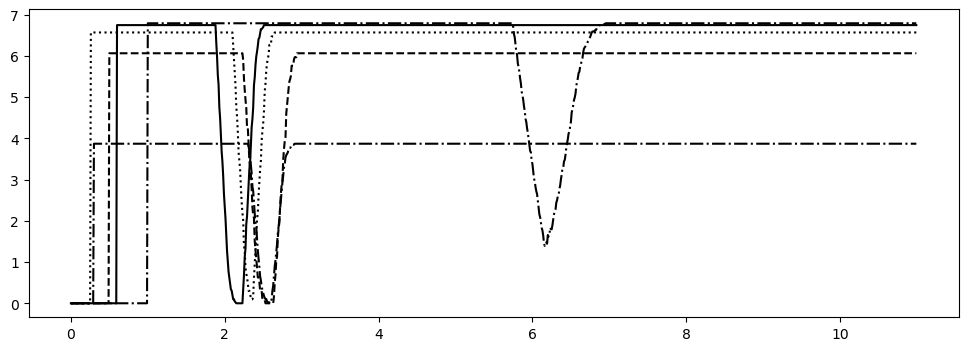

In [21]:
Elin = np.arange(0., 11000., 10.)
sac = np.array([])
curdir = os.getcwd()
os.chdir("/home/haue/repositories/Masters/analysis/python/twoproton")
for dssd, ssd, cutoff, thresh in zip(
    ["U1", "U2", "U3", "U4", "U6"], ["P1", "P2", "P3", "P4", "P6"], [600, 500, 260, 1000, 300], [280, 340, 180, 350, 220]): # P6 thresh: 220
    filename = "sam_21al_%s.dat" % dssd
    if not os.path.exists(filename):
        f = open(filename, "w")
        subprocess.call(["SAM", "-i45", "-d%s" % dssd], cwd="/home/haue/repositories/Masters/setup", stdout=f)
        f.close()
    sr = np.loadtxt(filename)
    #im = plt.imshow(100*np.transpose(sr)/(4*np.pi), extent=[0.5, 16.5, 16.5, 0.5], vmin=0., cmap=plt.cm.inferno)
    #cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    #plt.show()
    
    filename = "tdz_21al_%s.dat" % dssd
    if not os.path.exists(filename):
        f = open(filename, "w")
        subprocess.call(["TDZ", "-d%s,%s" % (dssd, ssd), "-i45", "--threshold=%s" % str(thresh)], cwd="/home/haue/repositories/Masters/setup/", stdout=f)
        f.close()
    
    v, fEdepmax, Elow, Eupp, fEdeplow, Esplow = np.loadtxt(filename, unpack=True)
    for i in range(len(Elin)):
        val = 0.
        if Elin[i] < cutoff:
#             print(Elin[i])
            sac = np.append(sac, val)
        else:
            # do not include outermost strips
            for j in range(0+1, 16-1):
                for k in range(0+1, 16-1):
                    if Esplow[j*16 + k] < Elin[i] and Elin[i] < Eupp[j*16 + k]:
#                         print(j, k, Elin[i])
                        pass
                    else:
                        val += sr[j, k]
            sac = np.append(sac, val)
            
os.chdir(curdir)     
sac_ = 100*sac/(4*np.pi)
sac1 = sac_[0:len(Elin)]
sac2 = sac_[len(Elin):2*len(Elin)]
sac3 = sac_[2*len(Elin):3*len(Elin)]
sac4 = sac_[3*len(Elin):4*len(Elin)]
sac6 = sac_[4*len(Elin):5*len(Elin)]
plt.figure(figsize=(12,4))
plt.plot(Elin/1e3, sac1, 'k-', label='U1-P1')
plt.plot(Elin/1e3, sac2, 'k--', label='U2-P2')
plt.plot(Elin/1e3, sac3, 'k:', label='U3-P3')
plt.plot(Elin/1e3, sac4, 'k-.', label='U4-P4')
plt.plot(Elin/1e3, sac6, 'k-.', label='U6-P6')

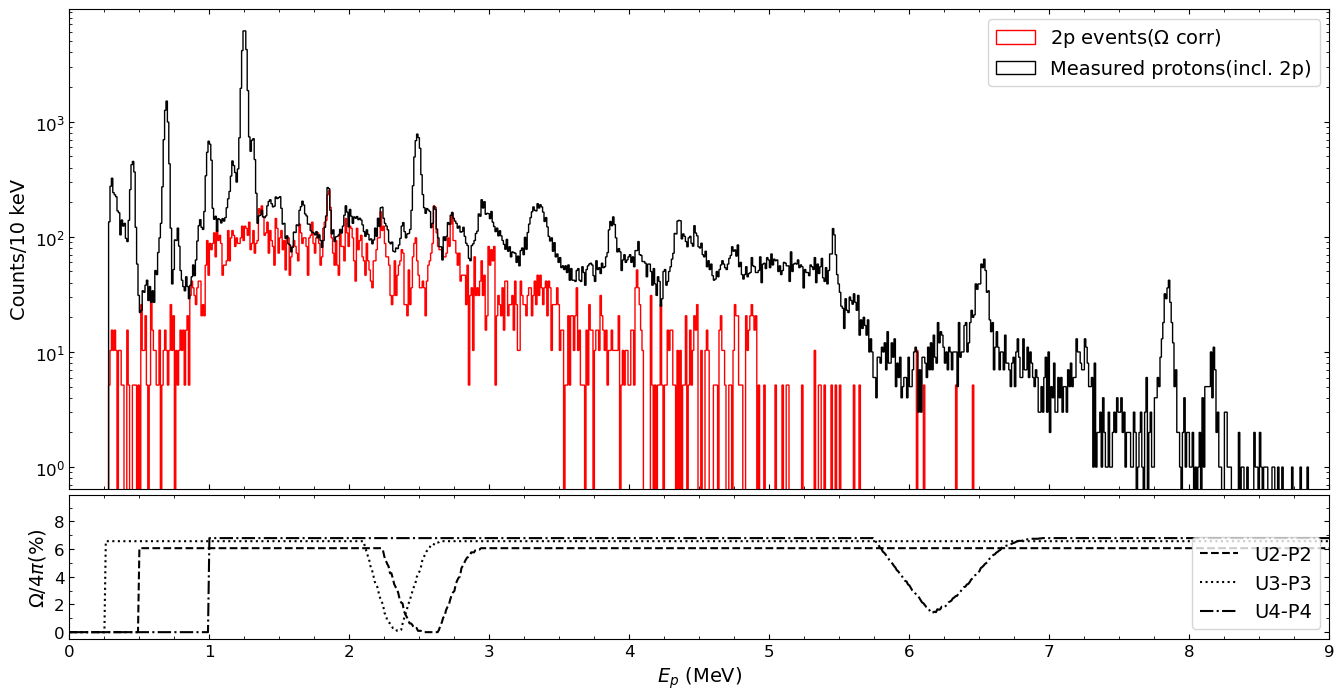

In [75]:
fs = 14
fs_ticks = 12
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(14, 7),gridspec_kw={'height_ratios': [1, 0.3]},sharex=True)
plt.subplots_adjust(hspace=0.02, top=0.96, bottom=0.06, left=0.08, right=0.98)

twoscale = 100/(np.max(sac1)+np.max(sac2)+np.max(sac3))

ax0 = axes[0]
ax0.hist(E2p/1e3, bins=np.arange(0, 9+0.01, 0.01), histtype='step', color='r', label=r"2p events($\Omega$ corr)",weights=twoscale*np.ones(len(E2p)))
ax0.hist(E2/1e3, bins=np.arange(0, 9+0.01, 0.01), histtype='step', color='k', label="Measured protons(incl. 2p)")
ax0.set_ylabel("Counts/10 keV", fontsize=fs)
ax0.set_yscale('log')
ax0.legend(fontsize=fs, loc='upper right')
ax0.tick_params(axis='x', bottom=True, top=True, labelbottom=False, labeltop=False, labelsize=fs_ticks, direction='in')

#ax0.set_title("Proton spectrum for U2-U4")


ax1 = axes[1]
ax1.plot(Elin/1e3, sac2, 'k--', label='U2-P2')
ax1.plot(Elin/1e3, sac3, 'k:',  label='U3-P3')
ax1.plot(Elin/1e3, sac4, 'k-.', label='U4-P4')
ax1.set_xlabel(r"$E_p$ (MeV)", fontsize=fs)
ax1.set_ylabel(r"$\Omega$/4$\pi$(%)", fontsize=fs)
ax1.legend(fontsize=fs, loc='lower right')
ax1.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=fs_ticks, direction='in')
ax1.tick_params(axis='y', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=fs_ticks, direction='in')
ax1.set_yticks(np.arange(0,10,1), minor=True)
ax1.set_yticks(np.arange(0,10,2))
ax1.set_xticks(np.arange(-1,10,1))
ax1.set_xticks(np.arange(-1,10,0.25), minor=True)

ax1.set_ylim(-0.5,9.9)
ax0.set_xlim(0, 9)


ax0.tick_params(axis='both', which='major', labelsize=fs_ticks)
ax1.tick_params(axis='both', which='major', labelsize=fs_ticks)

plt.show()

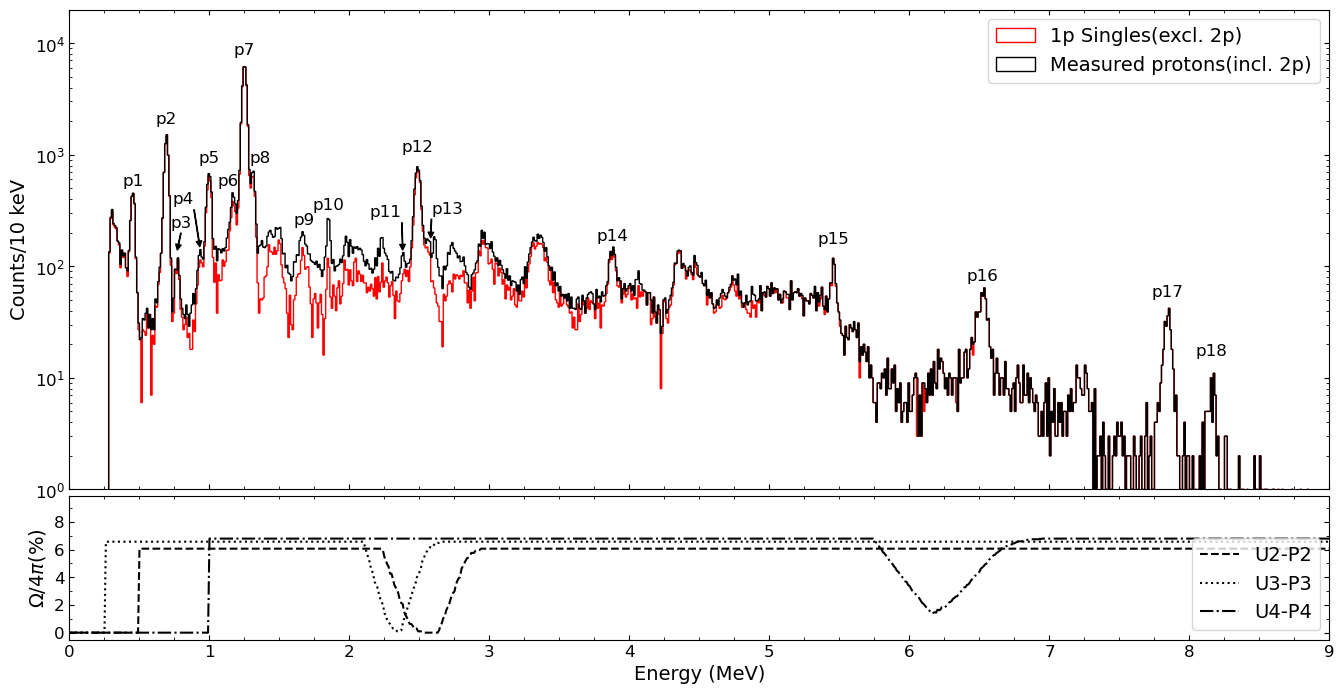

In [179]:
fs = 14
fs_ticks = 12
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(14, 7),gridspec_kw={'height_ratios': [1, 0.3]},sharex=True)
plt.subplots_adjust(hspace=0.02, top=0.96, bottom=0.06, left=0.08, right=0.98)

twoscale = 100/(np.max(sac1)+np.max(sac2)+np.max(sac3))

ax0 = axes[0]
ax0.hist(E/1e3, bins=np.arange(0, 9+0.01, 0.01), histtype='step', color='r', label="1p Singles(excl. 2p)")
ax0.hist(E2/1e3, bins=np.arange(0, 9+0.01, 0.01), histtype='step', color='k', label="Measured protons(incl. 2p)")
ax0.set_ylabel("Counts/10 keV", fontsize=fs)
ax0.set_yscale('log')
ax0.legend(fontsize=fs, loc='upper right')
ax0.tick_params(axis='x', bottom=True, top=True, labelbottom=False, labeltop=False, labelsize=fs_ticks, direction='in')


ax1 = axes[1]
ax1.plot(Elin/1e3, sac2, 'k--', label='U2-P2')
ax1.plot(Elin/1e3, sac3, 'k:',  label='U3-P3')
ax1.plot(Elin/1e3, sac4, 'k-.', label='U4-P4')
ax1.set_xlabel("Energy (MeV)", fontsize=fs)
ax1.set_ylabel(r"$\Omega$/4$\pi$(%)", fontsize=fs)
ax1.legend(fontsize=fs, loc='lower right')
ax1.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=fs_ticks, direction='in')
ax1.tick_params(axis='y', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=fs_ticks, direction='in')
ax1.set_yticks(np.arange(0,10,1), minor=True)
ax1.set_yticks(np.arange(0,10,2))
ax1.set_xticks(np.arange(-1,10,1))
ax1.set_xticks(np.arange(-1,10,0.25), minor=True)

ax1.set_ylim(-0.5,9.9)
ax0.set_xlim(0, 9)
ax0.set_ylim(1, 2e4)

ax0.tick_params(axis='both', which='major', labelsize=fs_ticks)
ax1.tick_params(axis='both', which='major', labelsize=fs_ticks)


es = [0.452, 0.692,0.770,0.931, 0.995, 1.130, 1.250, 1.360, 1.673, 1.850, 2.38, 2.486, 2.580,
      3.877, 5.456, 6.520, 7.844, 8.158]
arrow = [0.5*1e3, 1.8e3, (1.4e2,2.1e2,"cent"), (1.5e2, 3.4e2, "left"), 0.8e3, 0.5e3, 0.75e4, 0.8e3, 0.22e3, 0.3e3, (1.4e2,2.6e2, "left"), 1e3, (1.8e2,2.8e2, "right"),
         1.6e2, 1.5e2, 0.7e2, 0.5e2, 0.15e2]
i = 1
for e,a in zip(es,arrow):
    if isinstance(a, tuple):
        if a[2] == "left":
            ax0.annotate(f"p{i}", xy=(e, a[0]), xytext=(e-0.12, a[1]), arrowprops=dict(facecolor='k', edgecolor='k', width=0.3, headwidth=4, headlength=4), ha='center', va='bottom', fontsize=12, color='k')
        if a[2] == "right":
            ax0.annotate(f"p{i}", xy=(e, a[0]), xytext=(e+0.12, a[1]), arrowprops=dict(facecolor='k', edgecolor='k', width=0.3, headwidth=4, headlength=4), ha='center', va='bottom', fontsize=12, color='k')
        if a[2] == "cent":
            ax0.annotate(f"p{i}", xy=(e, a[0]), xytext=(e+0.03, a[1]), arrowprops=dict(facecolor='k', edgecolor='k', width=0.3, headwidth=4, headlength=4), ha='center', va='bottom', fontsize=12, color='k')
    else:
        ax0.annotate(f"p{i}", xy=(e, a), ha='center', va='bottom', fontsize=12, color='k')#, xytext=(e, a[1]), arrowprops=dict(facecolor='k', edgecolor='k', width=0.3, headwidth=4, headlength=4))
    i+=1


plt.show()